<a href="https://colab.research.google.com/github/JonathanLoscalzo/pytorch-tutorials/blob/master/Deep%20Learning%20with%20Pytorch/03_full_dataset_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning and text


In [0]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')
from tqdm.notebook import trange, tqdm


In [0]:
import torch
if torch.cuda.is_available():
  torch.device('cuda')

In [0]:
from torch import nn

### Gather Data

In [0]:
%%capture output
!pip install torchtext==0.6.0
import torchtext
import pandas as pd

Data were downloaded from http://help.sentiment140.com/for-students

In [5]:
# %%capture output
!wget -nc -nv http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip

2020-06-01 23:39:38 URL:https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip [81363704/81363704] -> "trainingandtestdata.zip" [1]


In [6]:
# %%capture output
!unzip -o trainingandtestdata.zip -d ./

Archive:  trainingandtestdata.zip
  inflating: ./testdata.manual.2009.06.14.csv  
  inflating: ./training.1600000.processed.noemoticon.csv  


## Start Learning


### Explore dataset
If you explore the ./content/... folder you will see 2 new files: 
- /content/testdata.manual.2009.06.14.csv: for testing purpose
- /content/training.1600000.processed.noemoticon.csv: for training purpose


In [0]:
# 0 - the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
# 1 - the id of the tweet (2087)
# 2 - the date of the tweet (Sat May 16 23:58:44 UTC 2009)
# 3 - the query (lyx). If there is no query, then this value is NO_QUERY.
# 4 - the user that tweeted (robotickilldozr)
# 5 - the text of the tweet (Lyx is cool)

columns = ['polarity', 'id', 'date', 'query', 'user', 'text']

In [8]:
data = pd.read_csv('./training.1600000.processed.noemoticon.csv', 
                   header=None,
                   encoding='latin')

data.columns = columns
data.sample(5)

,polarity,id,date,query,user,text
947652,4,1823121741,Sat May 16 21:10:03 PDT 2009,NO_QUERY,kickthehobbit,Why didn't I know about this http://bit.ly/wcN...
297306,0,1997364641,Mon Jun 01 16:43:17 PDT 2009,NO_QUERY,geneive,playing scrabble via facebook w/ kresta... thi...
758123,0,2295624430,Tue Jun 23 08:10:01 PDT 2009,NO_QUERY,xxMissJessicaxx,hello. long time no twit. longtime no sun either
506415,0,2188645998,Mon Jun 15 22:17:06 PDT 2009,NO_QUERY,raeganlovejonas,Going to bed. Another day of helping out at Ro...
1370111,4,2050957013,Fri Jun 05 19:36:00 PDT 2009,NO_QUERY,shelovestosing,@mytimetoshine girl... don't ask why! just be...


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int64 
 1   id        1600000 non-null  int64 
 2   date      1600000 non-null  object
 3   query     1600000 non-null  object
 4   user      1600000 non-null  object
 5   text      1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


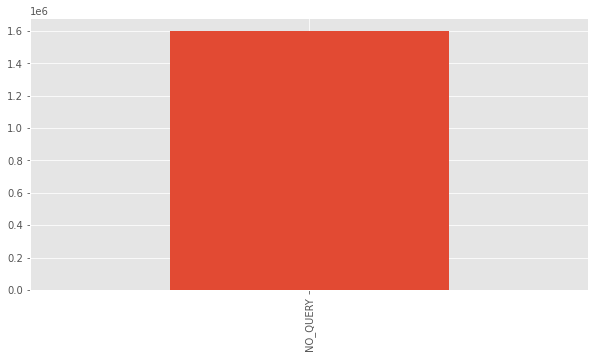

In [10]:
data.loc[:,'query'].value_counts()[0:10].plot.bar(figsize=(10,5))
plt.show()

The above graphs shows the feature "query".

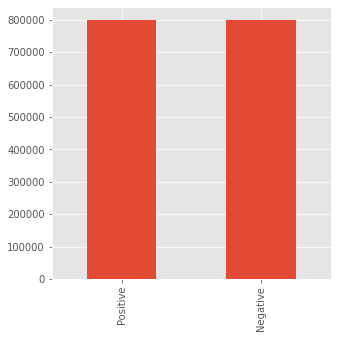

In [11]:
# (0 = negative, 2 = neutral, 4 = positive)
data['polarity'].value_counts()[0:10].plot.bar(figsize=(5,5))
plt.xticks([0,1],["Positive", "Negative"])
plt.show()

Save polarity as a category (0,1,2)

In [12]:
dtype = data['polarity'].astype('category').dtype
data['polarity_cat'] = data.polarity.astype(dtype)
data.polarity.value_counts()

4    800000
0    800000
Name: polarity, dtype: int64

In [0]:
data['old_polarity'] = data.polarity
data.polarity = data.polarity_cat.cat.codes

In [14]:
cats = pd.Series([0,4], dtype=dtype)

dictcats = { code: cat for code, cat in zip(cats.cat.codes.values, cats.cat.categories.values)}
print(dictcats, cats.cat.codes)
dictcats_names = { 0: "negative", 2: "neutral", 4: "positive" }

{0: 0, 1: 4} 0    0
1    1
dtype: int8


See some examples

In [15]:
print(data.iloc[data.text.str.count(' ').argsort()[-10::]].text.values)
print(data.text.str.count(' ').max())

["Heute Hannah Montana - Der Film                                                                  I'm Yours - Jason Mraz "
 'Guten Morgen Twitterland                         Happy Birthday Dad                                                I love you '
 'Ry, food in toaster oven-Cu in AM!                                                                        Gnight All!  '
 'I want to work                                                                            Just finished bathing :o'
 'Do you like matheW?                                                                                   SumMEr oH*9 (:'
 'loved seeing elena ! i love my worm  exhausted xx                                                                               __'
 '-----&gt;bite hard&lt;----                                                                                       damn this blows.'
 'will i ever stop feeling crappy?  all signs point to no.                                                            

In [16]:
data = data[["polarity","text"]]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   polarity  1600000 non-null  int8  
 1   text      1600000 non-null  object
dtypes: int8(1), object(1)
memory usage: 13.7+ MB


### TODO: Data Cleaning

### DataIngestion with Dataset and Example's


In [0]:
## Defining fields for the model
LABEL = torchtext.data.LabelField()
TWEET = torchtext.data.Field(tokenize='spacy', lower=True)

In [0]:
fields = [
  ('polarity', LABEL), 
  ('text', TWEET),
]


In [0]:
from sklearn.model_selection import train_test_split

data, _ = train_test_split(data, train_size=0.8, stratify=data.polarity, shuffle=True, random_state=42)
data_train, data_test = train_test_split(data, train_size=0.1, stratify=data.polarity, shuffle=True, random_state=42)
data_valid, data_test = train_test_split(data_test, stratify=data_test.polarity, train_size=0.1, shuffle=True)

In [0]:
def map_examples(data):
  examples=[]
  for ex in tqdm(data.values):
    examples.append(torchtext.data.Example.fromlist(ex, fields))
  return examples

In [21]:
examples_train = map_examples(data_train)
examples_valid = map_examples(data_valid)
examples_test = map_examples(data_test)

In [0]:
train = torchtext.data.Dataset(examples_train, fields)
test = torchtext.data.Dataset(examples_test, fields)
valid = torchtext.data.Dataset(examples_valid, fields)

In [23]:
# Build a vocabulary
%%timeit
vocab_size = 20000
TWEET.build_vocab(train, max_size = vocab_size)
LABEL.build_vocab(train)

1 loop, best of 3: 1.01 s per loop


In [0]:
train_iterator, valid_iterator, test_iterator = torchtext.data.BucketIterator.splits(
  (train, valid, test), 
  batch_size = 100, 
  device = 'cuda',
  shuffle=True,
  sort_key = lambda x: len(x.text),
  sort_within_batch = False
)

In [25]:
len(TWEET.vocab), len(LABEL.vocab)

(20002, 2)

### Defining a model

The iterator returns shape => (sequence_len, batch_size)
Embedding Layer:
- input ( * )
- output (*, embedding_size)

So embedding returns shape => (seq_len, batch_size, embedding_size)

Luego cualquier RNN, en este caso LSTM espera:
- Input (seq_len, batch_size, input_size)

- output: output, (h_n, c_n)
  - output: (seq_len, batch, num_directions * hidden_size)
  - h_n: (num_layers * num_directions, batch, hidden_size)
  - c_n:(num_layers * num_directions, batch, hidden_size)

In conclusion, input_size should be embedding_dim


Ver https://towardsdatascience.com/understand-how-to-use-namedtuple-and-dataclass-in-python-e82e535c3691

In [0]:
class ClassifierLSTM(nn.Module):
  def __init__(self, embedding_dim, vocab_size, hidden_size, 
               num_classes, num_layers=1, bidirectional=False,
               use_only_last_hidden=False):
    super(ClassifierLSTM, self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.bi = 2 if bidirectional else 1
    self.fc_inputs = hidden_size*num_layers*self.bi
    self.use_only_last_hidden = use_only_last_hidden

    # the words in our text are pushed into an Embedding layer,
    # https://pytorch.org/docs/stable/nn.html#embedding
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    # That’s then fed into a LSTM with hidden_size hidden features
    self.encoder = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=hidden_size, 
      num_layers=num_layers,
      bidirectional=bidirectional
    )

    # the final hidden state is pushed through a standard fully connected layer
    if use_only_last_hidden:
      self.predictor = nn.Linear(self.fc_inputs, num_classes)
    else:
      self.predictor = nn.Linear(hidden_size, num_classes)

  def forward(self, seq):
    output, (hidden,_) = self.encoder(self.embedding(seq))

    if self.use_only_last_hidden:
      return self.predictor(hidden.reshape(-1,self.fc_inputs))
    else:
      return self.predictor(hidden[-1].squeeze(0))

  def training_step(self, batch, loss_fn):
    inputs, labels = batch 
    out = self(inputs) # Generate predictions call forward method
    loss = loss_fn(out, labels) # Calculate loss
    return loss
    
  def validation_step(self, batch, loss_fn, metric):
    inputs, labels = batch 
    out = self(inputs)          # Generate predictions call forward method
    loss = loss_fn(out, labels) # Calculate loss
    acc = metric(out, labels)   # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}
        
  def validation_epoch_end(self, outputs):
    #TODO: refactor
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses

    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies

    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
  def epoch_end(self, epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, 
        result['val_loss'], 
        result['val_acc'])
    )
    print("*"*25)


In [0]:

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


def fit(epochs, model, train_iterator, val_loader, optimizer, loss_fn, scheduler=None, early_stopping=15):
  # TODO: return best_model
  history = []
  stopping_counter = 0
  best_metric = 0
  best_model=model.state_dict()

  for epoch in range(1,epochs+1):
    # Training Phase 
    model.train()
    for bix, batch in enumerate(train_iterator):
        inputs = (batch.text, batch.polarity)
        optimizer.zero_grad()
        loss = model.training_step(inputs, loss_fn)
        loss.backward()
        optimizer.step()
    
    # Validation phase
    model.eval()
    outputs = []
    for bix, batch in enumerate(val_loader):
      inputs = (batch.text, batch.polarity)
      optimizer.zero_grad()
      outputs.append(model.validation_step(inputs, loss_fn, accuracy))
    
    # Epoch Ended
    results = model.validation_epoch_end(outputs)
    history.append(results)
    model.epoch_end(epoch, results)

    # early stopping monitor
    if (best_metric < results["val_acc"]):
      stopping_counter = 0 
      best_metric=results["val_acc"]
      best_model=model.state_dict()
    else: 
      stopping_counter += 1

    # scheduler, reduce if corresponds (?) 
    if scheduler: 
      scheduler.step(epoch)
    
    if stopping_counter == early_stopping:
      print("Early stopping at epoch: ", epoch, " Best acc: ", best_metric)
      break

  return history, best_model

In [28]:
model = ClassifierLSTM(
  hidden_size=150, 
  embedding_dim=300, 
  vocab_size=len(TWEET.vocab),
  num_classes=2,
  num_layers=1,
  bidirectional=True,
  use_only_last_hidden=False
)
model.to('cuda')

ClassifierLSTM(
  (embedding): Embedding(20002, 300)
  (encoder): LSTM(300, 150, bidirectional=True)
  (predictor): Linear(in_features=150, out_features=2, bias=True)
)

In [0]:
# calculate gradients
loss_fn = torch.nn.CrossEntropyLoss()

In [0]:
# update parameters by optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, verbose=True)


In [0]:
history = []

In [32]:
actual_history, best_model = fit(50, model, train_iterator, valid_iterator, optimizer, loss_fn, scheduler)
history += actual_history

Epoch [1], val_loss: 0.4438, val_acc: 0.7995
*************************
Epoch [2], val_loss: 0.4270, val_acc: 0.8070
*************************
Epoch [3], val_loss: 0.4267, val_acc: 0.8107
*************************
Epoch [4], val_loss: 0.4633, val_acc: 0.8001
*************************
Epoch [5], val_loss: 0.5322, val_acc: 0.7931
*************************
Epoch [6], val_loss: 0.6011, val_acc: 0.7817
*************************
Epoch [7], val_loss: 0.6821, val_acc: 0.7786
*************************
Epoch [8], val_loss: 0.7916, val_acc: 0.7835
*************************
Epoch [9], val_loss: 0.8700, val_acc: 0.7782
*************************
Epoch [10], val_loss: 0.9115, val_acc: 0.7766
*************************
Epoch [11], val_loss: 0.9913, val_acc: 0.7693
*************************
Epoch [12], val_loss: 1.0649, val_acc: 0.7794
*************************
Epoch    12: reducing learning rate of group 0 to 1.0000e-04.
Epoch [13], val_loss: 1.0657, val_acc: 0.7794
*************************
Epoch [14],

In [0]:
torch.save(best_model, "./best_model.pt")

In [40]:
model.load_state_dict(best_model)

<All keys matched successfully>

### Learning History

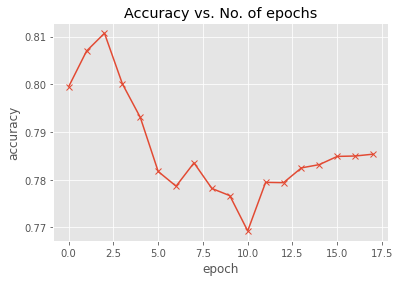

In [38]:
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

### Evaluate results in test data


In [43]:
acc = []
for batch in tqdm(test_iterator):
  with torch.no_grad():
    outputs = model(batch.text)
    acc.append(accuracy(outputs, batch.polarity).numpy())


In [46]:
print("Test performance: {:2f} +/- {:2f}".format(np.array(acc).mean(), np.array(acc).std()))

Test performance: 0.783088 +/- 0.044421


### Production (?)


In [0]:
def classify_tweet(tweet):
  categories = dictcats
  processed = TWEET.process([TWEET.preprocess(tweet)])
  processed = processed.to('cuda')
  with torch.no_grad():
    return dictcats_names[categories[model(processed).argmax().item()]]

In [75]:
#@title ### Test the model!
tweet_text = "I love you" #@param {type:"string"}
classify_tweet(tweet_text)

'negative'

## Next steps

- you can increase num_layers to create stacked LSTMs, 
- increase or decrease the number of hidden features in the layer, 
- set bidirectional=true to create a biLSTM. 

- replacing lstm wit gru
does it train faster? Is it more accurate? (Experiment and see what you find)